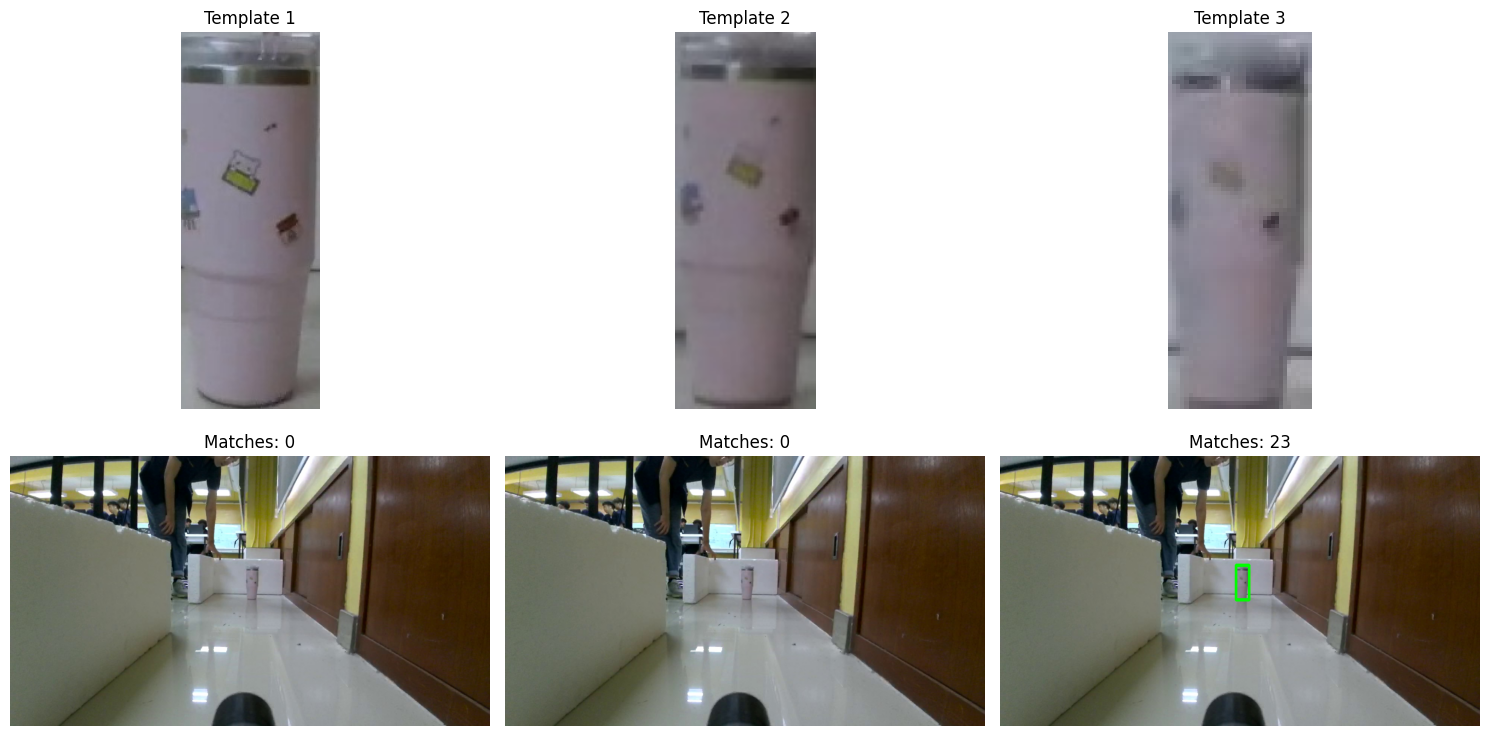

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. โหลดภาพหลัก
# ------------------------------
image = cv2.imread("C:/Users/User/.vscode/AI2.1/robot/work/image/capture_1756180115.jpg")
if image is None:
    raise FileNotFoundError("main_image.jpg not found")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ------------------------------
# 2. โหลด template สามชุด
# ------------------------------

template1 = "C:/Users/User/.vscode/AI2.1/robot/work/image/template/template_pic1_x_573_y_276_w_115_h_312.jpg"
template2 = "C:/Users/User/.vscode/AI2.1/robot/work/image/template/template_pic2_x_634_y_291_w_50_h_134.jpg"
template3 = "C:/Users/User/.vscode/AI2.1/robot/work/image/template/template_pic3_x_629_y_291_w_35_h_92.jpg"

template_files = [template1, template2, template3]
templates = []
for f in template_files:
    tmpl = cv2.imread(f)
    if tmpl is None:
        raise FileNotFoundError(f"{f} not found")
    templates.append(cv2.cvtColor(tmpl, cv2.COLOR_BGR2RGB))

# ------------------------------
# 3. ฟังก์ชัน matching RGB + multiple detections
# ------------------------------
def match_template_multiple(img, tmpl, threshold=0.8):
    # แยก channel แล้ว match เฉลี่ยผลลัพธ์
    results = []
    for c in range(3):  # R,G,B
        res = cv2.matchTemplate(img[:,:,c], tmpl[:,:,c], cv2.TM_CCOEFF_NORMED)
        results.append(res)
    result = np.mean(results, axis=0)

    # หา location ที่ score >= threshold
    locations = np.where(result >= threshold)
    boxes = []
    h, w, _ = tmpl.shape
    for pt in zip(*locations[::-1]):  # แปลง (row, col) -> (x, y)
        boxes.append((pt, (pt[0]+w, pt[1]+h)))
    return boxes, result

# ------------------------------
# 4. ทำ matching สำหรับทุก template
# ------------------------------
threshold = 0.7
matched_results = []
for tmpl in templates:
    boxes, result = match_template_multiple(image_rgb, tmpl, threshold)
    
    img_copy = image_rgb.copy()
    for top_left, bottom_right in boxes:
        cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
    
    matched_results.append((img_copy, tmpl, len(boxes)))

# ------------------------------
# 5. แสดงผลด้วย subplot
# ------------------------------
plt.figure(figsize=(15, 8))
for i, (img_res, tmpl_res, n_boxes) in enumerate(matched_results):
    # แถวบน: template
    plt.subplot(2, len(matched_results), i+1)
    plt.imshow(tmpl_res)
    plt.title(f"Template {i+1}")
    plt.axis("off")
    
    # แถวล่าง: ผล matching บนภาพ
    plt.subplot(2, len(matched_results), i+1+len(matched_results))
    plt.imshow(img_res)
    plt.title(f"Matches: {n_boxes}")
    plt.axis("off")

plt.tight_layout()
plt.show()


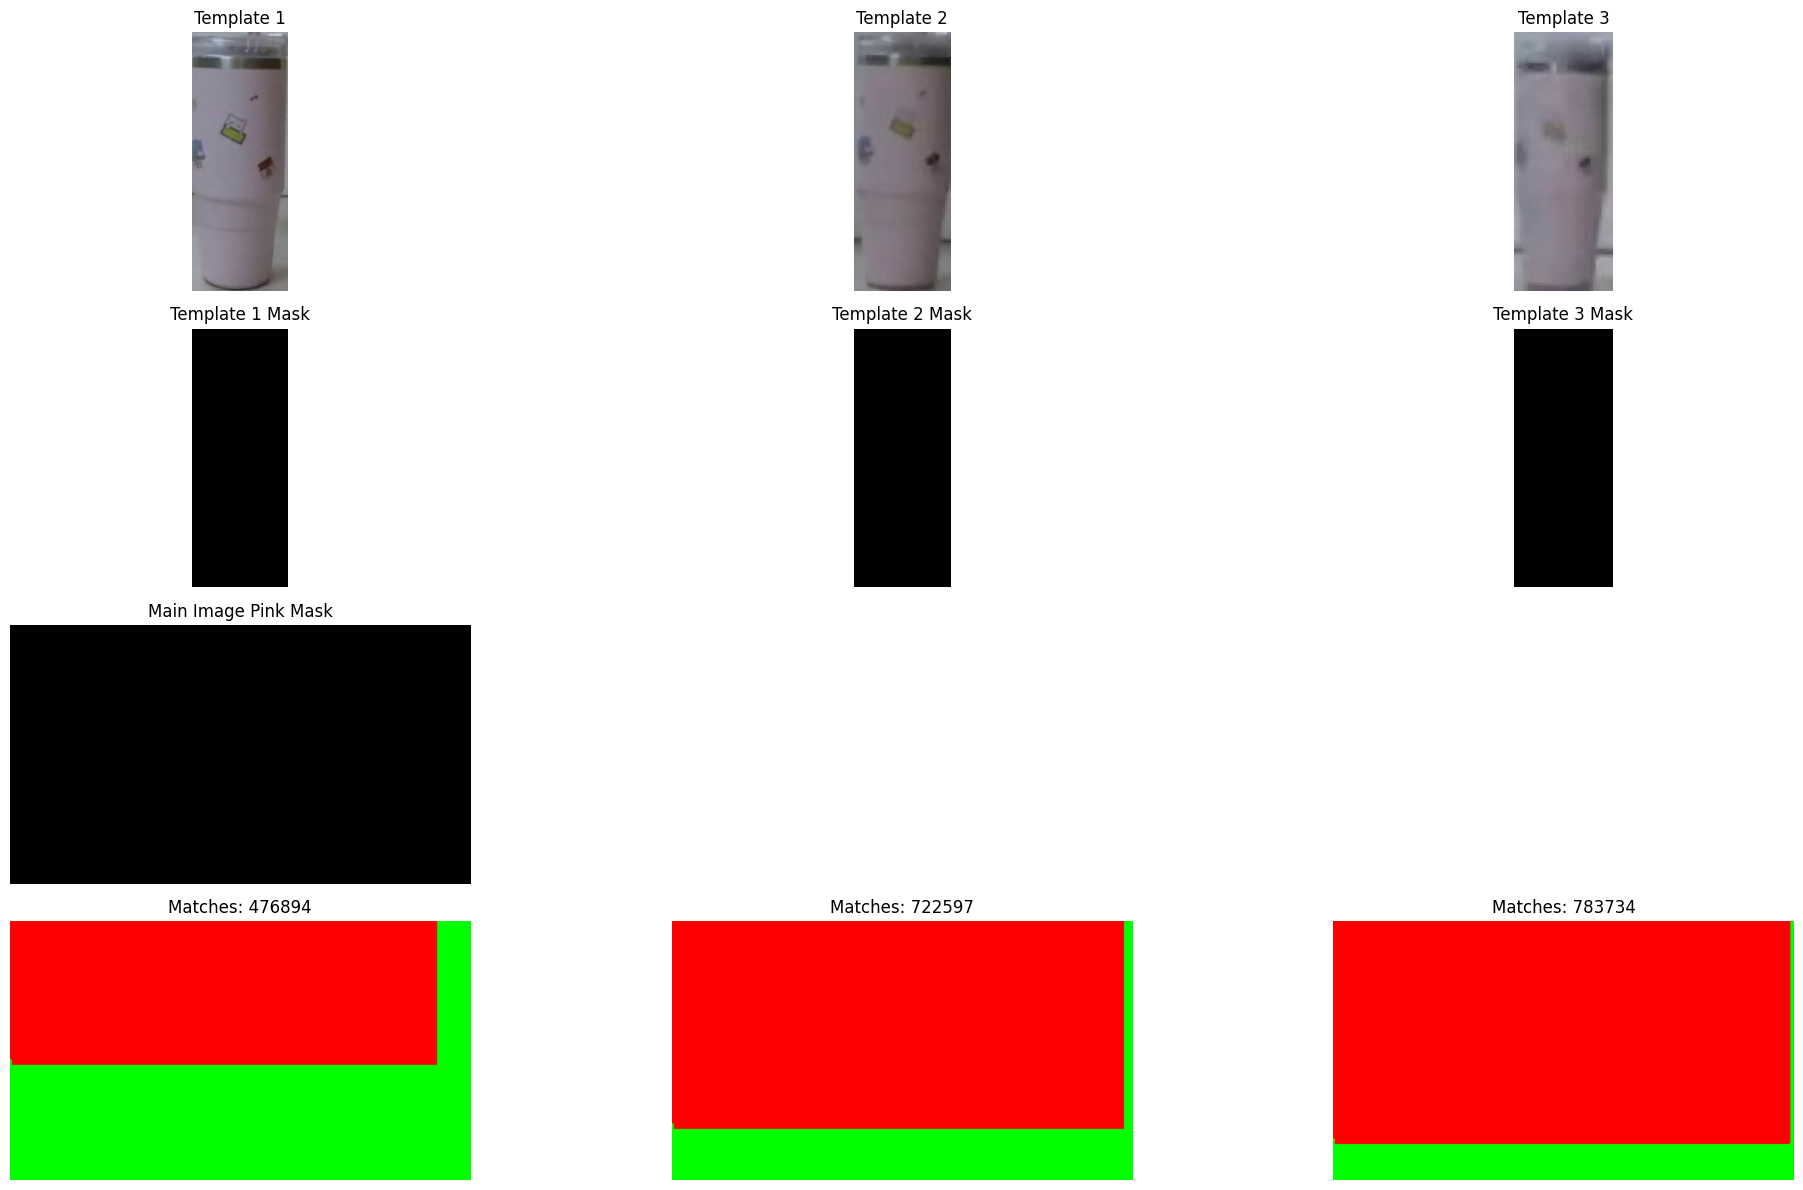

=== Template Matching Results ===
Template 1: พบ 476894 ตำแหน่ง
Template 2: พบ 722597 ตำแหน่ง
Template 3: พบ 783734 ตำแหน่ง

Threshold ที่ใช้: 0.6
Pink mask ถูกใช้เพื่อมุ่งเน้นเฉพาะพื้นที่สีชมพูในการค้นหา


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. โหลดภาพหลักและแปลงเป็น RGB
# ------------------------------
image = cv2.imread("C:/Users/User/.vscode/AI2.1/robot/work/image/capture_1756180004.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ------------------------------
# 2. สร้าง Pink Mask สำหรับภาพหลัก
# ------------------------------
def create_pink_mask(img_rgb):
    """สร้าง mask สำหรับสีชมพู"""
    # แปลงเป็น HSV เพื่อจับสีชมพูได้ดีกว่า
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    
    # ช่วงสีชมพู (ปรับได้ตามความเหมาะสม)
    # สีชมพูอ่อน
    lower_pink1 = np.array([140, 50, 100])   
    upper_pink1 = np.array([170, 255, 255])
    
    # สีชมพูเข้ม
    lower_pink2 = np.array([300, 50, 100])   
    upper_pink2 = np.array([330, 255, 255])
    
    # สร้าง mask
    mask1 = cv2.inRange(hsv, lower_pink1, upper_pink1)
    mask2 = cv2.inRange(hsv, lower_pink2, upper_pink2)
    pink_mask = cv2.bitwise_or(mask1, mask2)
    
    # เพิ่มการ morphology เพื่อลด noise
    kernel = np.ones((3,3), np.uint8)
    pink_mask = cv2.morphologyEx(pink_mask, cv2.MORPH_CLOSE, kernel)
    pink_mask = cv2.morphologyEx(pink_mask, cv2.MORPH_OPEN, kernel)
    
    return pink_mask

# สร้าง pink mask สำหรับภาพหลัก
main_pink_mask = create_pink_mask(image_rgb)

# แปลงภาพหลักเป็น grayscale และใช้ mask
main_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
main_masked = cv2.bitwise_and(main_gray, main_gray, mask=main_pink_mask)

# ------------------------------
# 3. โหลด template และเตรียม mask + grayscale
# ------------------------------
template1 = "C:/Users/User/.vscode/AI2.1/robot/work/image/template/template_pic1_x_573_y_276_w_115_h_312.jpg"
template2 = "C:/Users/User/.vscode/AI2.1/robot/work/image/template/template_pic2_x_634_y_291_w_50_h_134.jpg"
template3 = "C:/Users/User/.vscode/AI2.1/robot/work/image/template/template_pic3_x_629_y_291_w_35_h_92.jpg"

template_files = [template1, template2, template3]
templates_masked = []
templates_rgb = []

for f in template_files:
    tmpl = cv2.imread(f)
    if tmpl is None:
        raise FileNotFoundError(f"{f} not found")
    
    tmpl_rgb = cv2.cvtColor(tmpl, cv2.COLOR_BGR2RGB)
    templates_rgb.append(tmpl_rgb)
    
    # สร้าง pink mask สำหรับ template
    tmpl_pink_mask = create_pink_mask(tmpl_rgb)
    
    # แปลงเป็น grayscale และใช้ mask
    tmpl_gray = cv2.cvtColor(tmpl_rgb, cv2.COLOR_RGB2GRAY)
    tmpl_masked = cv2.bitwise_and(tmpl_gray, tmpl_gray, mask=tmpl_pink_mask)
    
    templates_masked.append(tmpl_masked)

# ------------------------------
# 4. ฟังก์ชันทำ Template Matching สำหรับ masked grayscale
# ------------------------------
def match_template_masked(img_masked, tmpl_masked, threshold=0.8):
    """Template matching บน masked grayscale images"""
    result = cv2.matchTemplate(img_masked, tmpl_masked, cv2.TM_CCOEFF_NORMED)
    
    # หา location ที่ score >= threshold
    locations = np.where(result >= threshold)
    
    boxes = []
    h, w = tmpl_masked.shape
    
    for pt in zip(*locations[::-1]):  # แปลง (row, col) -> (x, y)
        boxes.append((pt, (pt[0]+w, pt[1]+h)))
    
    return boxes, result

# ------------------------------
# 5. ทำ matching สำหรับทุก template
# ------------------------------
threshold = 0.6
matched_results = []

for i, tmpl_masked in enumerate(templates_masked):
    boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
    
    # วาดกรอบบนภาพต้นฉบับ (RGB)
    img_copy = image_rgb.copy()
    for top_left, bottom_right in boxes:
        cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
        # เพิ่มข้อความแสดงหมายเลข template
        cv2.putText(img_copy, f"T{i+1}", (top_left[0], top_left[1]-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    matched_results.append((img_copy, templates_rgb[i], len(boxes)))

# ------------------------------
# 6. แสดงผลด้วย subplot (เพิ่ม mask visualization)
# ------------------------------
plt.figure(figsize=(20, 12))

# แถวที่ 1: Templates
for i, (img_res, tmpl_res, n_boxes) in enumerate(matched_results):
    plt.subplot(4, len(matched_results), i+1)
    plt.imshow(tmpl_res)
    plt.title(f"Template {i+1}")
    plt.axis("off")

# แถวที่ 2: Template masks
for i, tmpl_masked in enumerate(templates_masked):
    plt.subplot(4, len(matched_results), i+1+len(matched_results))
    plt.imshow(tmpl_masked, cmap='gray')
    plt.title(f"Template {i+1} Mask")
    plt.axis("off")

# แถวที่ 3: Main image mask (แสดงเฉพาะรูปแรก)
plt.subplot(4, len(matched_results), 1+2*len(matched_results))
plt.imshow(main_masked, cmap='gray')
plt.title("Main Image Pink Mask")
plt.axis("off")

# แถวที่ 4: ผล matching บนภาพ
for i, (img_res, tmpl_res, n_boxes) in enumerate(matched_results):
    plt.subplot(4, len(matched_results), i+1+3*len(matched_results))
    plt.imshow(img_res)
    plt.title(f"Matches: {n_boxes}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ------------------------------
# 7. แสดงผลสรุป
# ------------------------------
print("=== Template Matching Results ===")
for i, (_, _, n_boxes) in enumerate(matched_results):
    print(f"Template {i+1}: พบ {n_boxes} ตำแหน่ง")

print(f"\nThreshold ที่ใช้: {threshold}")
print("Pink mask ถูกใช้เพื่อมุ่งเน้นเฉพาะพื้นที่สีชมพูในการค้นหา")

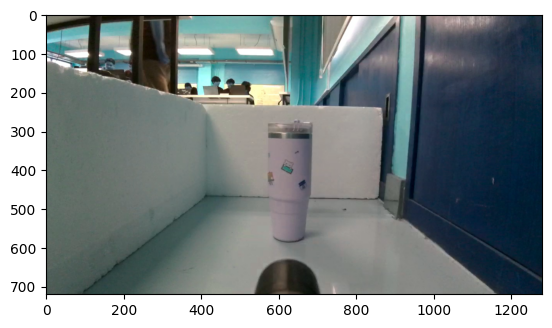

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. โหลดภาพหลักและแปลงเป็น RGB
# ------------------------------
image = cv2.imread("capture_1756180004.jpg")
plt.imshow(image)
plt.show()